In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.set_option('display.max_columns', 200)

## LOAD DATA

In [2]:
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean_cat.csv')
print(train.shape)
print(test.shape)

(91713, 183)
(39308, 183)


In [3]:
set(train.columns)-set(test.columns)

{'hospital_death'}

In [4]:
set(test.columns)-set(train.columns)

{'encounter_id'}

## DATA PREPARATION

In [5]:
# Apache Variables
apache_cov = ['albumin_apache','bilirubin_apache','bun_apache','creatinine_apache','glucose_apache','heart_rate_apache',
          'hematocrit_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','wbc_apache',
          'fio2_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache']
# 4 indicators
apache_indicators = ['apache_post_operative','arf_apache','intubated_apache','ventilated_apache']

# 8 Chronic health status
apache_chronic = ['aids','cirrhosis','diabetes_mellitus','hepatic_failure',
                  'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
# 6 others
apache_others =['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem','apache_2_bodysystem',
                'apache_4a_hospital_death_prob','apache_4a_icu_death_prob']

gcs = ['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache']

apache = apache_cov + apache_indicators + apache_chronic + apache_others + gcs
len(apache)

40

In [6]:
train.isnull().sum()

hospital_id                      0
hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
                              ... 
leukemia                       715
lymphoma                       715
solid_tumor_with_metastasis    715
apache_3j_bodysystem             0
apache_2_bodysystem              0
Length: 183, dtype: int64

In [7]:
#train.isnull().sum().sort_values(ascending=False)

### Create independent features X and dependant feature y

In [8]:
# Version 3: Exclude all APACHE covariates, but keep its unique information

#print(len(apache_cov))
#X = train.drop(columns=apache_cov).drop(columns='hospital_death',axis=1)
#y = train.hospital_death

#test = test_m.drop(columns=apache_cov)
#X.shape, test.shape

In [9]:
# Version 2: Exclude all APACHE variables

print("Apache column to drop:", len(apache))
X = train.drop(columns = apache).drop(columns = 'hospital_death',axis=1)
y = train.hospital_death

test = test.drop(columns = apache)
X.shape, test.shape

Apache column to drop: 40


((91713, 142), (39308, 143))

In [10]:
# Original: all Variables
#X = train_m.drop(columns=['hospital_death'])
#y = train_m.hospital_death

### Categorical Cols
These are categorical, will need to convert later on:
apache_2_diagnosis,apache_3j_diagnosis,apache_3j_diag_type, hospital_id

In [11]:
categorical_cols = [col for col in X.columns if  (X[col].dtype != 'float64')&(X[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

6


['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type']

### Encode categorical columns

**For Train dataset**

In [12]:
# Use this if excluding APACHE info
dummies = pd.get_dummies(X[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU'])

# Use this if APACHE bodysystem is used
#dummies = pd.get_dummies(X[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU', 'apache_3j_bodysystem_Unknown','apache_2_bodysystem_Unknown'])

print(dummies.shape)
X = pd.concat([X.drop(columns=categorical_cols),dummies],axis=1)
X.shape

(91713, 33)


(91713, 169)

**For Test dataset**

In [13]:
# Use this if excluding APACHE info
dummies = pd.get_dummies(test[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU'])

# Use this if APACHE bodysystem is used
#dummies = pd.get_dummies(test[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU', 'apache_3j_bodysystem_Unknown','apache_2_bodysystem_Unknown'])

print(dummies.shape)
test_m = pd.concat([test.drop(columns=categorical_cols),dummies],axis=1)
test_m = test_m.drop("encounter_id", axis=1)   # Drop encounter_id for test_m dataset to match train here
test_m.shape

(39308, 33)


(39308, 169)

### Remove Columns with more than 75% missing

In [14]:
train_missing = X.isnull().mean().sort_values(ascending = False)
train_missing = train_missing.index[train_missing > 0.75]
#print(train_missing)
X = X.drop(columns = train_missing)

test_m = test_m.drop(columns = train_missing)

print("Feature dimention is: ",X.shape, test_m.shape)

Feature dimention is:  (91713, 129) (39308, 129)


### Impute missing data with SimpleImputer

In [15]:
imputer = SimpleImputer(strategy = 'mean')
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.fit_transform(test_m)  # Use test's mean to impute

## TRAIN TEST SPLIT

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(68784, 129) (22929, 129)


## StandardScaler

In [17]:
# Instantiate our StandardScaler.
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)  # Scale X_train.
X_test_ss = ss.transform(X_test)  # Scale X_test.

## OVERSAMPLING THE MINORITY CLASS

In [18]:
y_train.value_counts(normalize=True)

0    0.913701
1    0.086299
Name: hospital_death, dtype: float64

In [19]:
## Oversampling on minority class
sm = SMOTE(k_neighbors=5,sampling_strategy = "minority",random_state=42)
X_sm, y_sm = sm.fit_sample(X_train_ss, y_train)

C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [20]:
print(np.bincount(y_train), np.bincount(y_sm))

[62848  5936] [62848 62848]


## MODELING - Logistic Regression

In [124]:
# Create variables to store results
search_model = []
search_best_score = []
search_best_estimator= []
search_params_list = []

name_list = []
model_list = []
scores_list = []
recall_list = []
specificity_list = []
precision_list = []
f1_list=[]
roc_list = []

In [125]:
# Create a function to store model performance
# Use standard name:
# X_test, y_test, probs (for predict_proba) 

def model_performance (name, model):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test_ss)).ravel()
    accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    recall    =  tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision =  tp/(tp+fp)
    f1_score  =  (2*precision*recall)/(precision + recall)
    roc = roc_auc_score(y_test,probs)

    name_list.append(name)
    model_list.append(model)
    scores_list.append(accuracy)
    recall_list.append(recall)
    specificity_list.append(specificity)
    precision_list.append(precision)
    f1_list.append(f1_score)
    roc_list.append(roc)
    
    metrics = pd.DataFrame([[name,roc,accuracy,recall,specificity,precision,f1_score]], columns = ['Model Name','ROC_AUC','Accuracy', "Recall", 'Specificity','Precision', 'F1_Score'])
    return metrics

In [126]:
# Create a function to store model performance after RandomizedSearchCV

# Use standard name:
# X_test, y_test, probs (for predict_proba) 

def model_performance_search (name, model):
    
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
    best_model = model.best_estimator_
    
    tn, fp, fn, tp = confusion_matrix(y_test, best_model.predict(X_test_ss)).ravel()
    accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    recall    =  tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision =  tp/(tp+fp)
    f1_score  =  (2*precision*recall)/(precision + recall)
    roc = roc_auc_score(y_test,probs)

    search_model.append(name)
    search_best_score.append(model.best_score_)
    search_best_estimator.append(model.best_estimator_)
    search_params_list.append(model.best_params_)
    
    name_list.append(name)
    model_list.append(model)
    scores_list.append(accuracy)
    recall_list.append(recall)
    specificity_list.append(specificity)
    precision_list.append(precision)
    f1_list.append(f1_score)
    roc_list.append(roc)

    metrics = pd.DataFrame([[name,roc,accuracy,recall,specificity,precision,f1_score]], columns = ['Model Name','ROC_AUC','Accuracy', "Recall", 'Specificity','Precision', 'F1_Score'])
    return metrics


In [21]:
cv = KFold(n_splits=5, random_state=42, shuffle=False)

### 1. Basic Logistic Regression

In [22]:
### 1. Train Logistic Regression on Oversampling dataset
logr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=200,, random_state=42)
logr.fit(X_sm, y_sm)
print(cross_val_score(logr, X_sm, y_sm, cv=cv,scoring='roc_auc').mean())

0.8414371104244218


In [23]:
# Apply the model to standardized X (not oversampled X)
probs = logr.predict_proba(X_train_ss)[:,1]
pred = logr.predict(X_train_ss)
print("X_train XROC AUC score is:", roc_auc_score(y_train,probs))

y_test_probs = logr.predict_proba(X_test_ss)[:,1]
print("X_test ROC AUC score is:", roc_auc_score(y_test,y_test_probs))

X_train XROC AUC score is: 0.8380481441597336
X_test ROC AUC score is: 0.8420345368613884


In [24]:
print("X_train accuracy:", logr.score(X_train_ss, y_train))
print("X_test accuracy:",logr.score(X_test_ss, y_test))

X_train accuracy: 0.77727378460107
X_test accuracy: 0.7797548955471237


In [25]:
# 2. Logistic Regression GridSearchCV
#params = {
#    'penalty': ['l1', 'l2', 'none'],
#    'C': np.logspace(-2,2,10),
#    'solver': ['lbfgs','liblinear']
#}

#logr = LogisticRegression(random_state=42)
#search = GridSearchCV(logr, params,scoring='roc_auc',cv=cv, verbose=10, n_jobs=-1)
#search.fit(X_sm,y_sm)

### 2. Logistic Regression - RandomSearchCV

In [26]:
# Logistic Regression RandomSearchCV
params = {
    'penalty': ['l1', 'l2', 'none'],
    'C': np.logspace(-2,2,10),
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

logr = LogisticRegression(random_state=42)
search = RandomizedSearchCV(logr, params,n_iter=30, scoring='roc_auc',cv=cv, verbose=10, n_jobs=-1,random_state=42)
search.fit(X_sm,y_sm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.33,
            train_size=None),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm...
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
             

In [27]:
best_logr = search.best_estimator_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 1.6681005372000592}
0.8414355876912948


In [127]:
probs = best_logr.predict_proba(X_test_ss)[:,1]
fpr,tpr,threshold = roc_curve(y_test,probs)

model_performance_search("Optimized Logistic Regression", search)

0.8414355876912948
{'solver': 'liblinear', 'penalty': 'l1', 'C': 1.6681005372000592}
LogisticRegression(C=1.6681005372000592, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


,Model Name,ROC_AUC,Accuracy,Recall,Specificity,Precision,F1_Score
0,Optimized Logistic Regression,0.842017,0.779799,0.742799,0.783294,0.244592,0.368006


In [29]:
best_logr

LogisticRegression(C=1.6681005372000592, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Performance Summary

In [129]:
results = pd.DataFrame({'model': name_list, 
                        'model_name': model_list,
                        'roc_auc': roc_list,
                        'accuracy': scores_list, 
                        'recall': recall_list, 
                        'specificity': specificity_list,
                        'precision': precision_list,
                        'f1_score': f1_list
                       })

results.to_csv('../data/ph1_logr_results.csv')
               
results

,model,model_name,roc_auc,accuracy,recall,specificity,precision,f1_score
0,Optimized Logistic Regression,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.842017,0.779799,0.742799,0.783294,0.244592,0.368006


### ROC Curve

In [37]:
def plot_roc_curve(fpr, tpr,model):
    plt.plot(fpr, tpr, label=model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
#    plt.show()

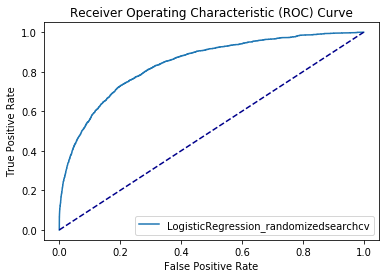

In [38]:
plot_roc_curve(fpr, tpr,'LogisticRegression_randomizedsearchcv')

#### Save the model to disk

In [52]:
# save the model to disk
filename = 'logr_randomizedsearchcv.sav'
pickle.dump(best_logr, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)


### Distribution

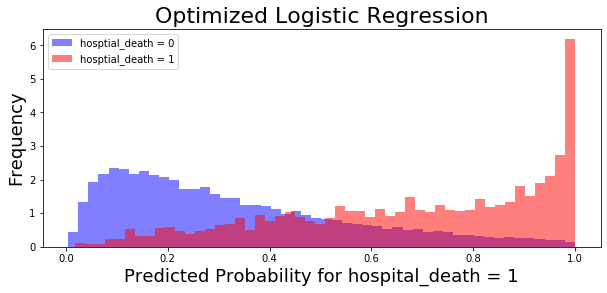

In [101]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':best_logr.predict_proba(X_test_ss)[:,1]})
# Create figure.
plt.figure(figsize = (10,4))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=50,
         color='b',
         alpha = 0.5,
         density=True,
         label='hosptial_death = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=50,
         color='red',
         alpha = 0.5,
         density=True,
         label='hosptial_death = 1')

# Label axes.
plt.title('Optimized Logistic Regression', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability for hospital_death = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=10);

In [71]:
pred_df

,true_values,pred_probs
24191,0,0.258250
44190,0,0.577060
61336,0,0.316022
88972,1,0.921424
78389,1,0.949055
...,...,...
73050,0,0.456798
50309,0,0.178818
48478,1,0.995690
70264,0,0.334352


### Feature Importance

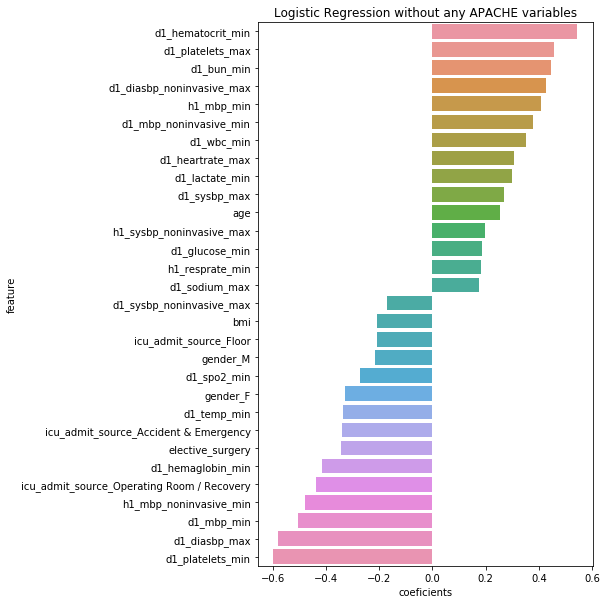

In [121]:
feature_imp_df = pd.DataFrame({"feature": X.columns, "coeficients": best_logr.coef_[0]}).sort_values(by="coeficients", ascending=False)
impt_features = pd.concat([feature_imp_df.head(15),feature_imp_df.tail(15)], axis=0)

# The most important features
plt.figure(figsize=(6,10))
sns.barplot(x="coeficients", y="feature", data=impt_features)
plt.title("Logistic Regression without any APACHE variables")
plt.show()

In [123]:
feature_imp_df['coef_abs'] = feature_imp_df.coeficients.abs()
threshold = 0.02
least_impt = feature_imp_df[feature_imp_df.coef_abs<threshold]
least_impt

,feature,coeficients,coef_abs
26,d1_sysbp_invasive_max,0.019927,0.019927
100,ethnicity_Native American,0.019892,0.019892
0,hospital_id,0.017382,0.017382
37,h1_diasbp_noninvasive_min,0.015927,0.015927
36,h1_diasbp_noninvasive_max,0.015234,0.015234
106,hospital_admit_source_Emergency Department,0.014957,0.014957
114,hospital_admit_source_SDU,0.013018,0.013018
9,d1_diasbp_invasive_min,0.012169,0.012169
92,d1_arterial_po2_max,0.008128,0.008128
22,d1_resprate_max,0.005090,0.005090


## Submission

In [ ]:
pred_logr = logr.predict_proba(test_imputed)[:,1]
pred_results = pd.DataFrame({'encounter_id':test_df.encounter_id, 'hospital_death': pred_logr})
pred_results.to_csv('../data/pred_logr.csv',index=False)
pred_results.head()